In [344]:
import functools
import seaborn as sns
from scipy import stats

sns.set_context('paper')

from IPython.display import display

### Load Database

In [148]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [229]:
db = DB('earthfury-alliance', timerange=30)

### Calc Best Price

In [380]:

@functools.lru_cache(maxsize=1)
def daily_max(item):
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)['minBuyout'].max()

def price_at_salerate(item, salerate):
    dm = daily_max(item)
    return dm.quantile(1-salerate)

# def salerate_at_price(item, price):
#     # inverse of quantile, seems to work with some slight numerical error
#     dm = daily_max(item)
#     return 1-stats.percentileofscore(dm, price)/100

def postcost_at_salerate(item, salerate):
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

In [402]:
daily_max(2840)

scannedAt
2020-04-28     7.13
2020-04-29     6.93
2020-04-30     6.98
2020-05-01     5.30
2020-05-02     4.23
2020-05-03     4.21
2020-05-04    10.00
2020-05-05     4.98
2020-05-06     7.25
2020-05-07     7.49
2020-05-08     8.99
2020-05-09     4.78
2020-05-10     4.09
2020-05-11     3.33
2020-05-12     3.25
2020-05-13     2.92
2020-05-14     2.75
2020-05-15     3.75
2020-05-16     3.05
2020-05-17     2.66
2020-05-18     4.90
2020-05-19     4.49
2020-05-20     3.49
2020-05-21     3.01
2020-05-22     3.21
2020-05-23     4.89
2020-05-24    10.00
2020-05-25     7.00
2020-05-26     4.66
2020-05-27     8.75
Name: minBuyout, dtype: float64

Copper Bar


,item_id,name,quantity,saleRate,salePrice,postCost,profit,profitDaily,profitDailyNorm
58,2840,Copper Bar,561,0.93,2.9227,0.004516,2.918184,2.713911,0.574981


,item_id,name,quantity,saleRate,salePrice,postCost,profit,profitDaily,profitDailyNorm
0,2840,Copper Bar,561,0.35,5.2520,0.111429,5.140571,1.799200,0.381186
1,2840,Copper Bar,561,0.36,5.1592,0.106667,5.052533,1.818912,0.385363
2,2840,Copper Bar,561,0.37,5.0664,0.102162,4.964238,1.836768,0.389146
3,2840,Copper Bar,561,0.38,4.9784,0.097895,4.880505,1.854592,0.392922
4,2840,Copper Bar,561,0.39,4.9552,0.093846,4.861354,1.895928,0.401680
...,...,...,...,...,...,...,...,...,...
61,2840,Copper Bar,561,0.96,2.7772,0.002500,2.774700,2.663712,0.564346
62,2840,Copper Bar,561,0.97,2.7383,0.001856,2.736444,2.654351,0.562362
63,2840,Copper Bar,561,0.98,2.7122,0.001224,2.710976,2.656756,0.562872
64,2840,Copper Bar,561,0.99,2.6861,0.000606,2.685494,2.658639,0.563271


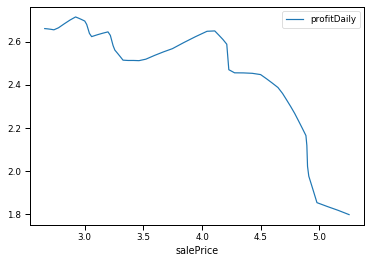

In [441]:
def analysis(item, show=False):
    # exclude low sale rates because
    # a) they're higher risk as capital is tied up longer
    # b) data in the low end can be swayed by unrealistice prices
    minSaleRate = 35 
    
    data = []
    medianPice = price_at_salerate(item, .5) # is this reliable, probably? Its the max price for the day, of the lowest day.
    for saleRate in range(minSaleRate,101):
        saleRate   /= 100
        salePrice   = price_at_salerate(item, saleRate)
        postCost    = postcost_at_salerate(item, saleRate)
        profit      = salePrice - postCost
        profitDaily = profit / (1 + (1-saleRate)/saleRate)  # normalize return by time to sell
        profitDailyNorm = profitDaily / medianPice     # normalize return by tied up capital
        
        data.append({
            'item_id': item,
            'name': db.get_name(item),         
            'quantity': db.get_last_record(item)['quantity'],
            'saleRate': saleRate,
            'salePrice': salePrice,
            'postCost': postCost,
            'profit': profit,
            'profitDaily': profitDaily,   
            'profitDailyNorm' : profitDailyNorm
            })
    df = pd.DataFrame(data)
    best = df.loc[df['profitDailyNorm'] == df['profitDailyNorm'].max()]
    if show:
        print(db.get_name(item))
        display(best)
        display(df)
        df.plot(x='salePrice', y='profitDaily')
        
    return best.to_dict('r')[0]

row = analysis(2840, show=True)

### Run Analysis

In [421]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  bags        : 38 items
  eng         : 53 items
  ALL         : 266 items



In [422]:
# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(ALL, analysis)

running for 266 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
 ...110 done
 ...120 done
! ERROR - 5467, Kodo Meat
 ...130 done
 ...140 done
! ERROR - 20748, Brilliant Mana Oil
! ERROR - 20749, Brilliant Wizard Oil
! ERROR - 21546, Elixir of Greater Firepower
 ...150 done
 ...160 done
 ...170 done
! ERROR - 21023, Dirge's Kickin' Chimaerok Chops
 ...180 done
 ...190 done
 ...200 done
 ...210 done
 ...220 done
 ...230 done
 ...240 done
! ERROR - 4399, Wooden Stock
! ERROR - 4400, Heavy Stock
 ...250 done
 ...260 done
COMPLETE


### Export

In [443]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [456]:
# format for export (note, 100x to scale integer copper)
df['buy_price']    = 100 * df['salePrice'] * .9 # insure a 5% profit (10% minus 5% ah cut)
df['min_price']    = 100 * df['salePrice']
df['normal_price'] = 100 * df['salePrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
df['max_price']    = 100 * df['salePrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
df = df.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})

In [457]:
def set_restock_value(item):
    if item in herbs + skinning:
        return 70
    if item in cloth + mining:
        return 70
    if item in bags:
        return 1
    if item in eng:
        return 15
    return 50

df['restock'] = df['item_id'].apply(set_restock_value)

In [458]:
# is this actually a rank? It's probably just the best price for each item
choice = df.query('quantity > 100').sort_values(by='profitDailyNorm').tail(30)
choice

,item_id,name,saleRate,salePrice,postCost,profit,profitDaily,profitDailyNorm,quantity,buy_price,min_price,normal_price,max_price,restock
34,14047,Runecloth,1.00,7.30,0.00,7.30,7.30,0.74,7259,657,730,803,803,70
242,4402,Small Flame Sac,0.93,115.91,0.11,115.80,107.69,0.74,127,10431,11591,12750,12750,15
48,3858,Mithril Ore,1.00,10.70,0.00,10.70,10.70,0.74,117,963,1070,1177,1177,70
159,3387,Limited Invulnerability Potion,0.96,288.16,0.01,288.15,276.62,0.74,224,25934,28816,31697,31697,50
147,9206,Elixir of Giants,1.00,107.50,0.00,107.50,107.50,0.75,138,9675,10750,11825,11825,50
22,8839,Blindweed,0.89,68.17,0.28,67.89,60.43,0.75,186,6135,6817,7498,7498,70
252,7912,Solid Stone,0.86,30.03,0.10,29.93,25.74,0.76,304,2702,3003,3303,3303,15
81,16202,Lesser Eternal Essence,0.89,216.73,0.00,216.73,192.89,0.76,128,19505,21673,23840,23840,50
18,8846,Gromsblood,1.00,46.47,0.00,46.47,46.47,0.77,490,4182,4647,5111,5111,70
26,13467,Icecap,0.97,51.74,0.05,51.69,50.14,0.77,277,4656,5174,5691,5691,70


In [459]:
EXPORT(choice)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SRunecloth^T^SaboveMax^SmaxPrice^SnormalPrice^S803^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S803^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S730^SkeepQtySources^T^t^Sblacklist^S^t^SSmall Flame Sac^T^SaboveMax^SmaxPrice^SnormalPrice^S12750^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S12750^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S11591^SkeepQtySources^T^t^Sblacklist^S^t^SMithril Ore^T^SaboveMax^SmaxPrice^SnormalPrice^S1177^Sduration^N3^SmatchStackSize^

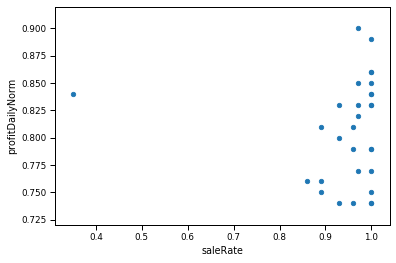

In [462]:
choice.plot(kind='scatter', x='saleRate', y='profitDailyNorm')

In [464]:
other = df.loc[~df['item_id'].isin(choice['item_id'])]
EXPORT(other)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SArthas' Tears^T^SaboveMax^SmaxPrice^SnormalPrice^S548^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S548^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S499^SkeepQtySources^T^t^Sblacklist^S^t^SBlack Lotus^T^SaboveMax^SmaxPrice^SnormalPrice^S1706566^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S1706566^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S1551424^SkeepQtySources^T^t^Sblacklist^S^t^SPlaguebloom^T^SaboveMax^SmaxPrice^SnormalPrice^S18711^Sduration^N3^SmatchSta